This dataset was taken from kaggle 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

: 

Step 1: Load the dataset


In [34]:
data = pd.read_csv("Walmart.csv") 
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Data preprocessing

In [35]:
data['Date'] = pd.to_datetime(data['Date'],dayfirst=True)
data = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
data.set_index('Date', inplace=True)
data.head()

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


Train test split    

In [36]:
train_size = int(len(data) * 0.8)  # 80% training, 20% testing
train, test = data.iloc[:train_size], data.iloc[train_size:]

Defining the evaluation models

In [37]:
def evaluate_model(model_name, train, test, predictions):
    mse = mean_squared_error(test['Weekly_Sales'], predictions)
    print(f"{model_name} Mean Squared Error: {mse}")
    return mse

Using models good for Time-series analysis such as ARIMA and prophet to predict the future sales

In [38]:
hw_model = ExponentialSmoothing(
    train['Weekly_Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=52
)
hw_fit = hw_model.fit()
hw_predictions = hw_fit.forecast(steps=len(test))
hw_mse = evaluate_model("Holt-Winters", train, test, hw_predictions)

#ARIMA model
arima_model = ARIMA(train['Weekly_Sales'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(test))
arima_mse = evaluate_model("ARIMA", train, test, arima_predictions)

Holt-Winters Mean Squared Error: 4847183544559.429
ARIMA Mean Squared Error: 15398828549832.5


/Users/bhargavaa/Documents/Internship/Walmart project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/bhargavaa/Documents/Internship/Walmart project/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/bhargavaa/Documents/Internship/Walmart project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/bhargavaa/Documents/Internship/Walmart project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/bhargavaa/Do

In [39]:
#data preparation for the prophet model

prophet_data = train.reset_index().rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

In [40]:
prophet_model = Prophet()
prophet_model.fit(prophet_data)

17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
future = prophet_model.make_future_dataframe(periods=len(test))
prophet_forecast = prophet_model.predict(future)

In [42]:
prophet_predictions = prophet_forecast.tail(len(test))['yhat']
prophet_mse = evaluate_model("Prophet", train, test, prophet_predictions)

Prophet Mean Squared Error: 2984774407505.09


In [43]:
results = {
    "Holt-Winters": hw_mse,
    "ARIMA": arima_mse,
    "Prophet": prophet_mse
}
best_model = min(results, key=results.get)
print(f"\nThe best model is: {best_model} with MSE: {results[best_model]}")


The best model is: Prophet with MSE: 2984774407505.09


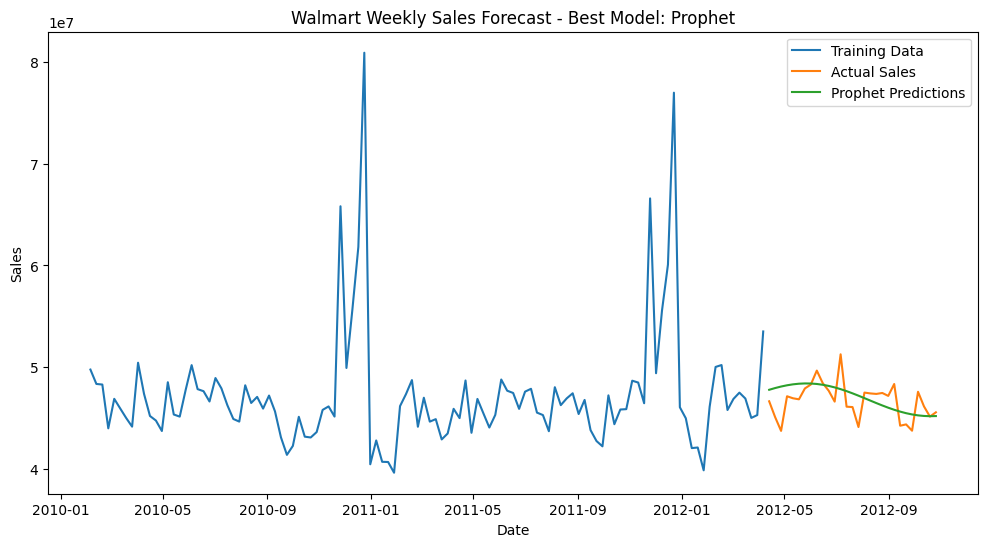

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Weekly_Sales'], label='Training Data')
plt.plot(test.index, test['Weekly_Sales'], label='Actual Sales')

if best_model == "Holt-Winters":
    plt.plot(test.index, hw_predictions, label='Holt-Winters Predictions')
elif best_model == "ARIMA":
    plt.plot(test.index, arima_predictions, label='ARIMA Predictions')
elif best_model == "Prophet":
    plt.plot(test.index, prophet_predictions, label='Prophet Predictions')

plt.title(f'Walmart Weekly Sales Forecast - Best Model: {best_model}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()